In [33]:
import os
# running from Root directory
os.chdir("..")

In [34]:
from connectome import Connectome
from connectome_network import ConnectomeNetwork
from connectome_types import SynapseSide, cell_types, ClfType, m_types, CONNECTOME_SYN_TABLE_PATH, CONNECTOME_NEURON_TABLE_PATH
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from collections import Counter

In [35]:
Conn = Connectome(from_disk=True)

Connectome:
	#neurons: 71736
	#synapses: 13506902


In [36]:
inh_mat = Conn.get_neuron_conn_matrix(ClfType.inhibitory)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13506902/13506902 [00:34<00:00, 388336.74it/s]


In [37]:
inh_neurons = list(Conn.neurons[Conn.neurons.clf_type == ClfType.inhibitory].root_id)
print(f'total inh neurons: {len(inh_neurons)}')
print(f'total connections: {np.sum(inh_mat)}')
print(f'max synapses between a pair of neurons: {np.amax(inh_mat)}')

max_post_idx, max_pre_idx = np.unravel_index(inh_mat.argmax(), inh_mat.shape)
max_pre_id = inh_neurons[max_pre_idx]
max_post_id = inh_neurons[max_post_idx]

print(f'the max pair indices (pre-post): {max_pre_idx, max_post_idx}')
print(f'the max pair root ids (pre-post): {max_pre_id, max_post_id}')

total inh neurons: 7832
total connections: 941139
max synapses between a pair of neurons: 62
the max pair indices (pre-post): (5682, 6538)
the max pair root ids (pre-post): (864691136108712632, 864691136379657429)


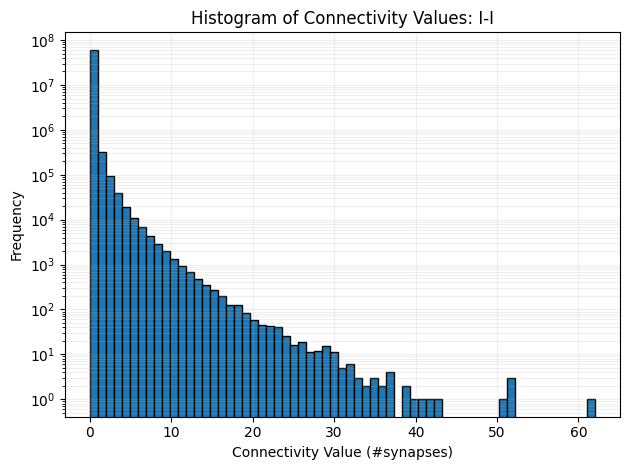

Total elements (N*N): 61340224
Non-zero elements: 512784
Percentage of non-zero elements: 0.84%
Min value: 0
Max value: 62
Mean value: 0.02
Median value: 0.0


In [38]:
flattened_matrix = inh_mat.flatten()

plt.hist(flattened_matrix, bins=63, range=(0, 62), edgecolor='black')
plt.title('Histogram of Connectivity Values: I-I')
plt.xlabel('Connectivity Value (#synapses)')
plt.ylabel('Frequency')
plt.yscale('log') 
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()

print(f"Total elements (N*N): {flattened_matrix.size}")
print(f"Non-zero elements: {np.count_nonzero(flattened_matrix)}")
print(f"Percentage of non-zero elements: {np.count_nonzero(flattened_matrix) / flattened_matrix.size * 100:.2f}%")
print(f"Min value: {flattened_matrix.min()}")
print(f"Max value: {flattened_matrix.max()}")
print(f"Mean value: {flattened_matrix.mean():.2f}")
print(f"Median value: {np.median(flattened_matrix)}")

In [62]:
# from matplotlib.colors import LogNorm
# z_filtered = inh_mat + 1e-10
# c = plt.imshow(z_filtered, cmap='viridis', norm=LogNorm(vmin=z_filtered.min(), vmax=z_filtered.max()))
# cbar = plt.colorbar(c)
# cbar.set_label('Log scale')
# plt.title('Inhibitory Connectivity Matrix')
# plt.show()

# from matplotlib.colors import ListedColormap
# custom_cmap = ListedColormap(['white', 'black'])
# binary_mask = (inh_mat > 0).astype(int)

# im = plt.imshow(binary_mask, cmap=custom_cmap, aspect='auto')
# plt.colorbar(im, label='Connectivity')
# plt.title('Connectivity Matrix (White: 0, Black: >0)')
# plt.tight_layout()
# plt.show()

## Clustering

In [39]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
Z = linkage(inh_mat, 'ward')

threshold: 264.659325624812
Data point 0: Cluster 1


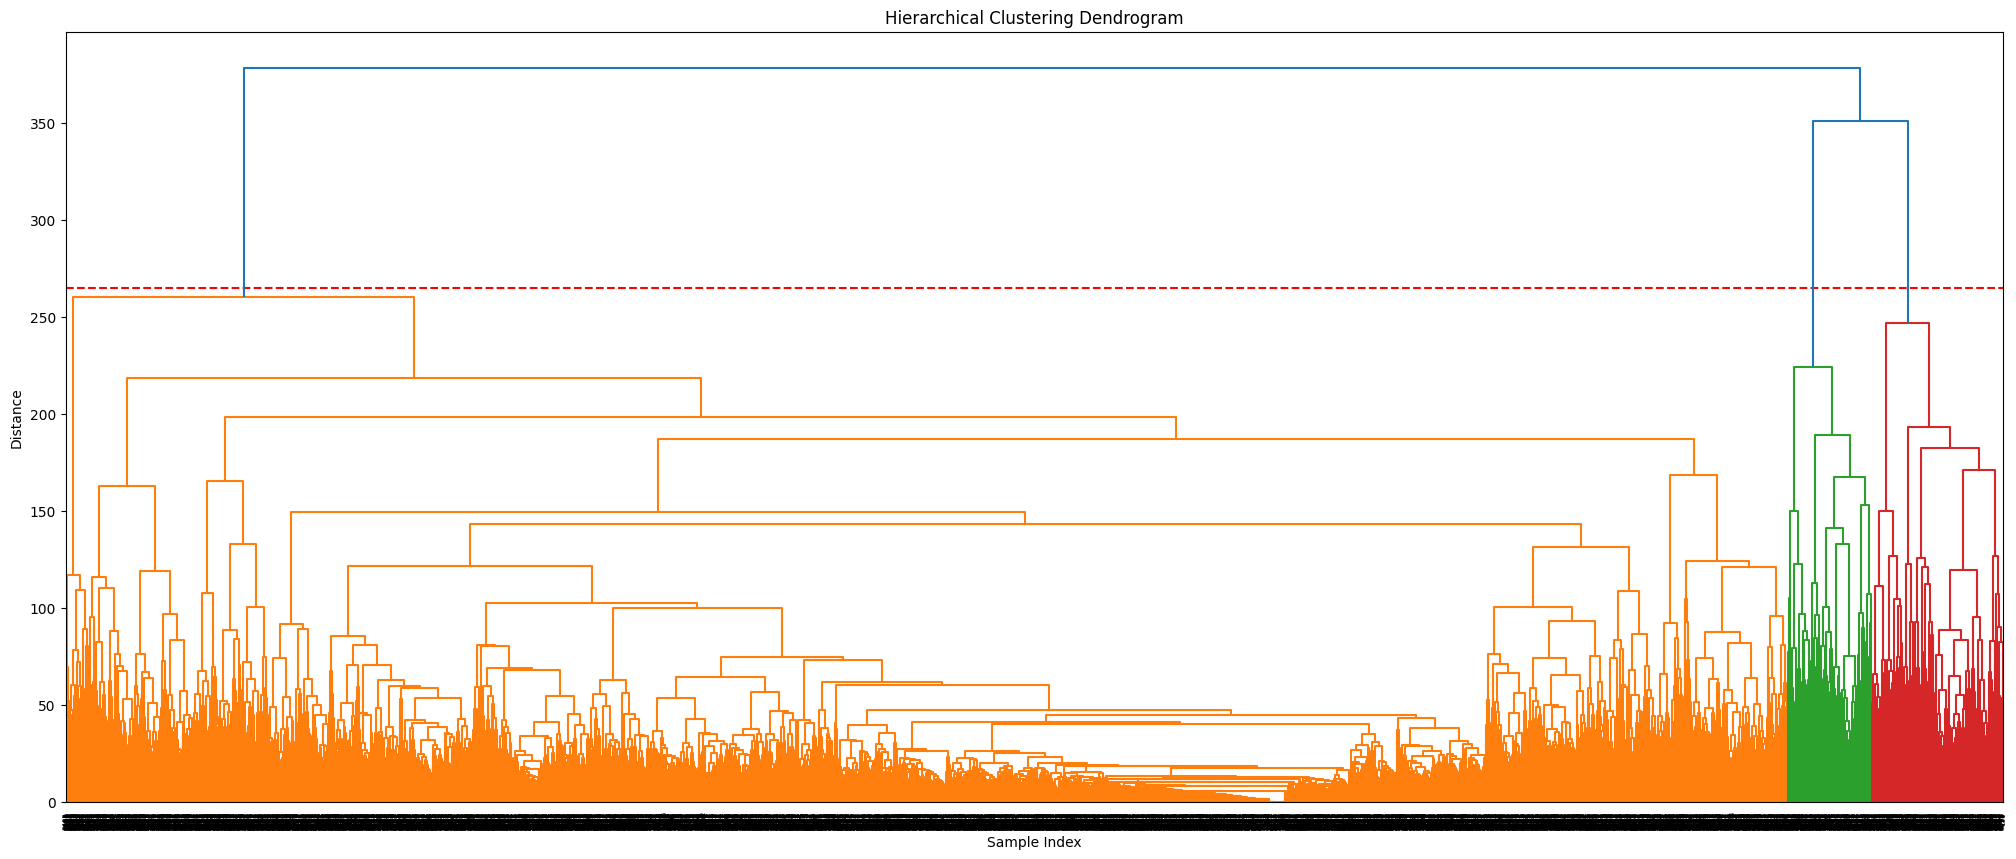

In [59]:
fig = plt.figure(figsize=(25, 10))
threshold = 0.7*max(Z[:,2]) # default
plt.axhline(y=threshold, color='r', linestyle='--')

clusters = fcluster(Z, threshold, criterion='distance')
# for i, cluster in enumerate(clusters):
#     print(f"Data point {i}: Cluster {cluster}")
print(f"threshold: {threshold}")
print(f"Data point {0}: Cluster {clusters[0]}")

dn = dendrogram(Z, color_threshold = threshold)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

values, counts = np.unique(clusters, return_counts=True)
print(f'num of clusters {len(counts)}')
counts

In [50]:
# # example
# matrix = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
# Z = linkage(matrix, method='ward')
# threshold = 5
# plt.axhline(y=threshold, color='r', linestyle='--')
# clusters = fcluster(Z, threshold, criterion='distance')
# for i, cluster in enumerate(clusters):
#     print(f"Data point {i}: Cluster {cluster}")

# dn = dendrogram(Z, color_threshold=threshold)
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('Sample Index')
# plt.ylabel('Distance')
# plt.show()

# leaf_labels = dn['leaves']
# # print("Leaf order:", leaf_labels)
# for i, leaf in enumerate(leaf_labels):
#     print(f"Leaf {i}: {matrix[leaf]}")